# Movies Recommender System

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, evaluate

import warnings; warnings.simplefilter('ignore')

In [2]:
md = pd. read_csv('movies_metadata.csv')
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
md = md.drop([19730, 29503, 35587])
md['id'] = md['id'].astype('int')

md.shape

(45463, 25)

## Content Based Recommender

In [3]:
links_small = pd.read_csv('links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [4]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9099, 25)

We have **9099** movies avaiable in our small movies metadata dataset which is 5 times smaller than our original dataset of 45000 movies.

### Movie Description Based Recommender

In [5]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [6]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=2, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [7]:
tfidf_matrix.shape

(9099, 34602)

#### Cosine Similarity
<center>$cosine(x,y) = \frac{x. y^\intercal}{||x||.||y||} $</center>

In [8]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [9]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [10]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [11]:
get_recommendations('The Hitchhiker\'s Guide to the Galaxy').head(10)

6388                  The Wild Blue Yonder
6634                  The Canterbury Tales
1112         Star Trek IV: The Voyage Home
6983    Journey to the Center of the Earth
6933            Stargate: The Ark of Truth
8915                       Robot Overlords
2659             What Planet Are You From?
5805                       The Ice Pirates
7091         The Day the Earth Stood Still
966                                  Alien
Name: title, dtype: object

In [12]:
get_recommendations('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
7933         Sherlock Holmes: A Game of Shadows
2696                                        JFK
Name: title, dtype: object

### Personalization

In [13]:
reader = Reader()

In [14]:
ratings = pd.read_csv('ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [15]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
data.split(n_folds=5)

In [16]:
svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.8946
MAE:  0.6892
------------
Fold 2
RMSE: 0.9048
MAE:  0.6953
------------
Fold 3
RMSE: 0.9024
MAE:  0.6953
------------
Fold 4
RMSE: 0.8914
MAE:  0.6892
------------
Fold 5
RMSE: 0.8928
MAE:  0.6861
------------
------------
Mean RMSE: 0.8972
Mean MAE : 0.6910
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.8946241869032118,
                             0.9048306529073029,
                             0.9023840530091664,
                             0.891381788883386,
                             0.8927996296483333],
                            'mae': [0.689241844297828,
                             0.6953007434647135,
                             0.6952506105075816,
                             0.6891916958794686,
                             0.6861351972997323]})

In [17]:
trainset = data.build_full_trainset()
svd.train(trainset)

In [30]:
user1df = ratings[ratings['userId'] == 1]
user1df['est_rating'] = user1df.apply(lambda x: svd.predict(x['userId'], x['movieId']).est, axis = 1)
user1df.head()

,userId,movieId,rating,timestamp,est_rating
0,1,31,2.5,1260759144,2.349966
1,1,1029,3.0,1260759179,2.768164
2,1,1061,3.0,1260759182,2.669915
3,1,1129,2.0,1260759185,2.352411
4,1,1172,4.0,1260759205,3.304238


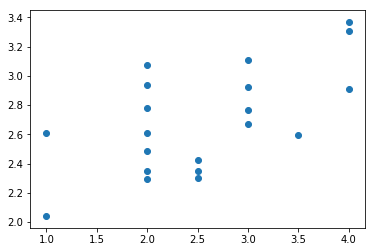

In [31]:
plt.scatter(user1df.rating, user1df.est_rating)

In [32]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [34]:
id_map = pd.read_csv('links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')

In [35]:
indices_map = id_map.set_index('id')

In [36]:
def personal_recommendation(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    # todo add your own tricky logic here
    return movies.head(10)

In [38]:
personal_recommendation(userId=1, title='Avatar')

,title,vote_count,vote_average,year,id,est
975,A Grand Day Out,199.0,7.4,1990,530,3.265700
2059,The Matrix,9079.0,7.9,1999,603,3.264054
3360,The Dish,62.0,6.6,2000,5257,2.911218
1898,A Simple Plan,191.0,6.9,1998,10223,2.864261
4804,Avalon,93.0,6.8,2001,10881,2.826776
2910,Pandora and the Flying Dutchman,19.0,6.5,1951,38688,2.751375
7460,Green Zone,730.0,6.4,2010,22972,2.747445
6083,Walker,16.0,6.4,1987,28448,2.743617
4506,Tears of the Sun,582.0,6.4,2003,9567,2.601174
5229,Ambush,13.0,6.3,1999,49320,2.599704


In [40]:
personal_recommendation(userId=500, title='Avatar')

,title,vote_count,vote_average,year,id,est
975,A Grand Day Out,199.0,7.4,1990,530,3.619684
2910,Pandora and the Flying Dutchman,19.0,6.5,1951,38688,3.435904
2854,The Hidden,85.0,6.7,1987,12476,3.375058
3018,Rocketship X-M,15.0,5.1,1950,37744,3.304537
4506,Tears of the Sun,582.0,6.4,2003,9567,3.169608
3360,The Dish,62.0,6.6,2000,5257,3.083359
1898,A Simple Plan,191.0,6.9,1998,10223,3.075409
4804,Avalon,93.0,6.8,2001,10881,3.065466
4328,Dog Soldiers,227.0,6.7,2002,11880,3.002436
7587,The American,488.0,5.8,2010,27579,2.998508
